# Potato Disease Classification

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import tensorflow as tf
from tensorflow.keras import models,layers
from matplotlib import pyplot as plt

In [3]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS = 3
EPOCHS = 50

## Import data into tensorflow dataset object

In [4]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
    shuffle = True,
    image_size = (IMAGE_SIZE,IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [5]:
class_names= dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

## Visualize some of the images from our dataset

(32, 256, 256, 3)
[1 0 0 1 2 0 0 1 0 0 1 1 1 1 1 0 0 1 1 0 1 1 1 0 1 1 1 0 0 0 0 0]


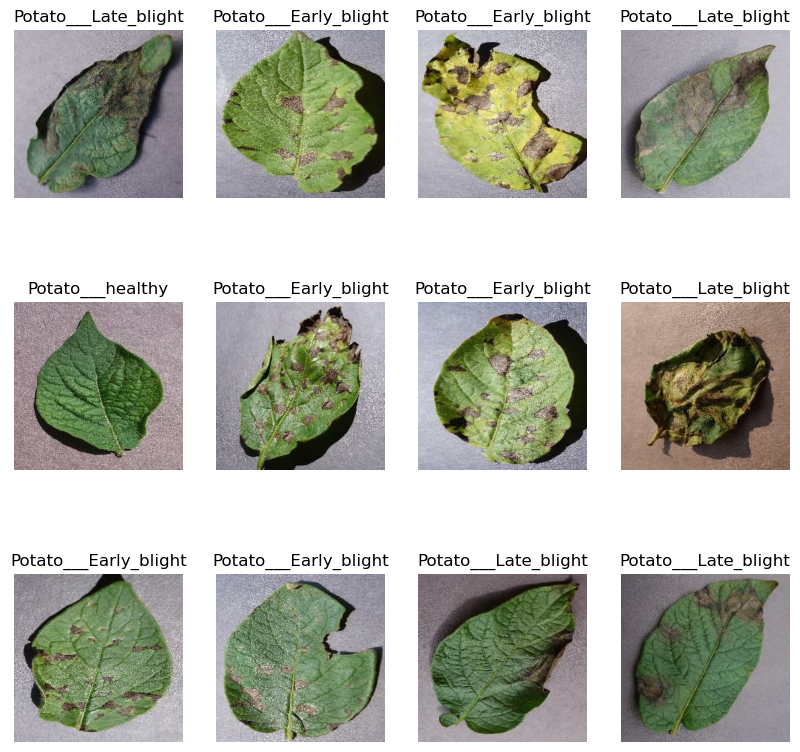

In [6]:
plt.figure(figsize = (10,10))
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())
    for i in range(12):
        ax = plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [7]:
train_size = 0.8
len(dataset)*train_size

54.400000000000006

In [8]:
train_ds = dataset.take(54)
len(train_ds)

54

In [9]:
test_ds = dataset.skip(54)
len(test_ds)

14

In [10]:
val_size = 0.1
len(dataset)*val_size

6.800000000000001

In [11]:
val_ds = test_ds.take(6)
len(val_ds)

6

In [12]:
test_ds = test_ds.skip(6)
len(test_ds)

8

In [13]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [14]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [15]:
len(train_ds)

54

In [16]:
len(val_ds)

6

In [17]:
len(test_ds)

8

# Cache, Shuffle, and Prefetch the Dataset

In [18]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

# Building the Model

### Creating a Layer for Resizing and Normalization

In [19]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

### Data Augmentation

Data Augmentation is needed when we have less data, this boosts the accuracy of our model by augmenting the data.

In [20]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [34]:
n_classes = 3
input_shape = (BATCH_SIZE, IMAGE_SIZE, CHANNELS)
model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation = 'relu', input_shape =input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size = (3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size = (3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size = (3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size = (3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size = (3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64, activation = 'relu'),
    layers.Dense(n_classes, activation = 'sigmoid'),
])


In [35]:
model.build(input_shape = (32,356,256,3))

In [36]:
 model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (256, 256, 3)             0         
                                                                 
 conv2d_12 (Conv2D)          (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d_12 (MaxPoolin  (32, 127, 127, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_13 (MaxPoolin  (32, 62, 62, 64)         0         
 g2D)                                                            
                                                                 
 conv2d_14 (Conv2D)          (32, 60, 60, 64)         

In [37]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)


In [38]:
history = model.fit(
    train_ds,
    batch_size = BATCH_SIZE,
    validation_data = val_ds,
    verbose = 1,
    epochs = EPOCHS,
)

Epoch 1/50
54/54 [==============================] - 161s 3s/step - loss: 0.9071 - accuracy: 0.5023 - val_loss: 0.8213 - val_accuracy: 0.4844
Epoch 2/50
54/54 [==============================] - 203s 4s/step - loss: 0.7630 - accuracy: 0.6516 - val_loss: 0.5025 - val_accuracy: 0.8021
Epoch 3/50
54/54 [==============================] - 220s 4s/step - loss: 0.4582 - accuracy: 0.8108 - val_loss: 0.3167 - val_accuracy: 0.8542
Epoch 4/50
54/54 [==============================] - 144s 3s/step - loss: 0.3133 - accuracy: 0.8762 - val_loss: 0.3960 - val_accuracy: 0.8281
Epoch 5/50
54/54 [==============================] - 138s 3s/step - loss: 0.3247 - accuracy: 0.8663 - val_loss: 0.2421 - val_accuracy: 0.9167
Epoch 6/50
54/54 [==============================] - 134s 2s/step - loss: 0.1714 - accuracy: 0.9329 - val_loss: 0.1682 - val_accuracy: 0.9167
Epoch 7/50
54/54 [==============================] - 128s 2s/step - loss: 0.1837 - accuracy: 0.9265 - val_loss: 0.1310 - val_accuracy: 0.9427
Epoch 8/50
54

54/54 [==============================] - 120s 2s/step - loss: 2.2753e-05 - accuracy: 1.0000 - val_loss: 0.0070 - val_accuracy: 0.9948
Epoch 49/50
54/54 [==============================] - 116s 2s/step - loss: 2.1449e-05 - accuracy: 1.0000 - val_loss: 0.0071 - val_accuracy: 0.9948
Epoch 50/50
54/54 [==============================] - 114s 2s/step - loss: 1.9914e-05 - accuracy: 1.0000 - val_loss: 0.0071 - val_accuracy: 0.9948


In [39]:
scores = model.evaluate(test_ds)

8/8 [==============================] - 7s 597ms/step - loss: 0.0013 - accuracy: 1.0000


In [40]:
scores

[0.0012895804829895496, 1.0]

In [41]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 54}

In [43]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [45]:
history.history['loss']

[0.907126247882843,
 0.7630152106285095,
 0.458183616399765,
 0.31331971287727356,
 0.32470810413360596,
 0.17143478989601135,
 0.18366509675979614,
 0.1306835561990738,
 0.09818216413259506,
 0.08012036234140396,
 0.06030353903770447,
 0.09125729650259018,
 0.10681646317243576,
 0.07129352539777756,
 0.031558696180582047,
 0.014879809692502022,
 0.012837667018175125,
 0.017557673156261444,
 0.05973198264837265,
 0.02780819684267044,
 0.10521087050437927,
 0.08174463361501694,
 0.0677599310874939,
 0.023817457258701324,
 0.006080821622163057,
 0.0018205834785476327,
 0.00048296229215338826,
 0.000279498053714633,
 0.00021257622574921697,
 0.0001629777834750712,
 0.00013508640404324979,
 0.00011303280189167708,
 9.721638343762606e-05,
 8.455388160655275e-05,
 7.421379996230826e-05,
 6.612505239900202e-05,
 5.888654413865879e-05,
 5.285358929540962e-05,
 4.785250348504633e-05,
 4.35783585999161e-05,
 3.973615093855187e-05,
 3.629281127359718e-05,
 3.3645301300566643e-05,
 3.0853359930915

In [46]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

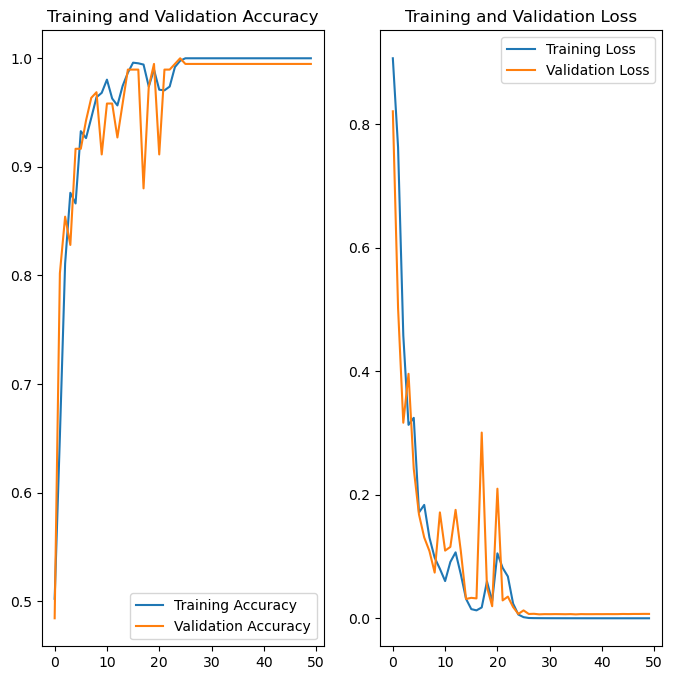

In [47]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

The graph is telling us that in start our accuracy was very low starting from 0.5 but it increased as our epochs increased, after the final epoch our accuracy was 1.0 whuch means our model is perfect.
Similarly our loss was high st start but started to decrease as our epochs increased.

### Run Prediction for a Sample image

first image to predict
actual label: Potato___Early_blight
1/1 [==============================] - 1s 564ms/step
predicted label: Potato___Early_blight


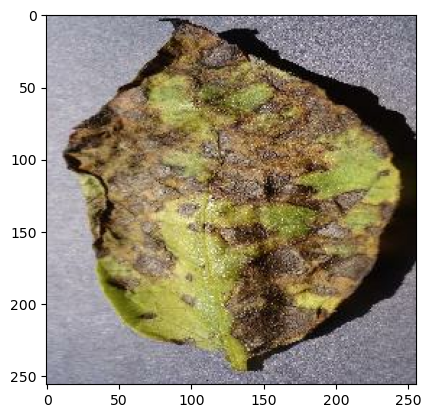

In [53]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [54]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 44ms/step


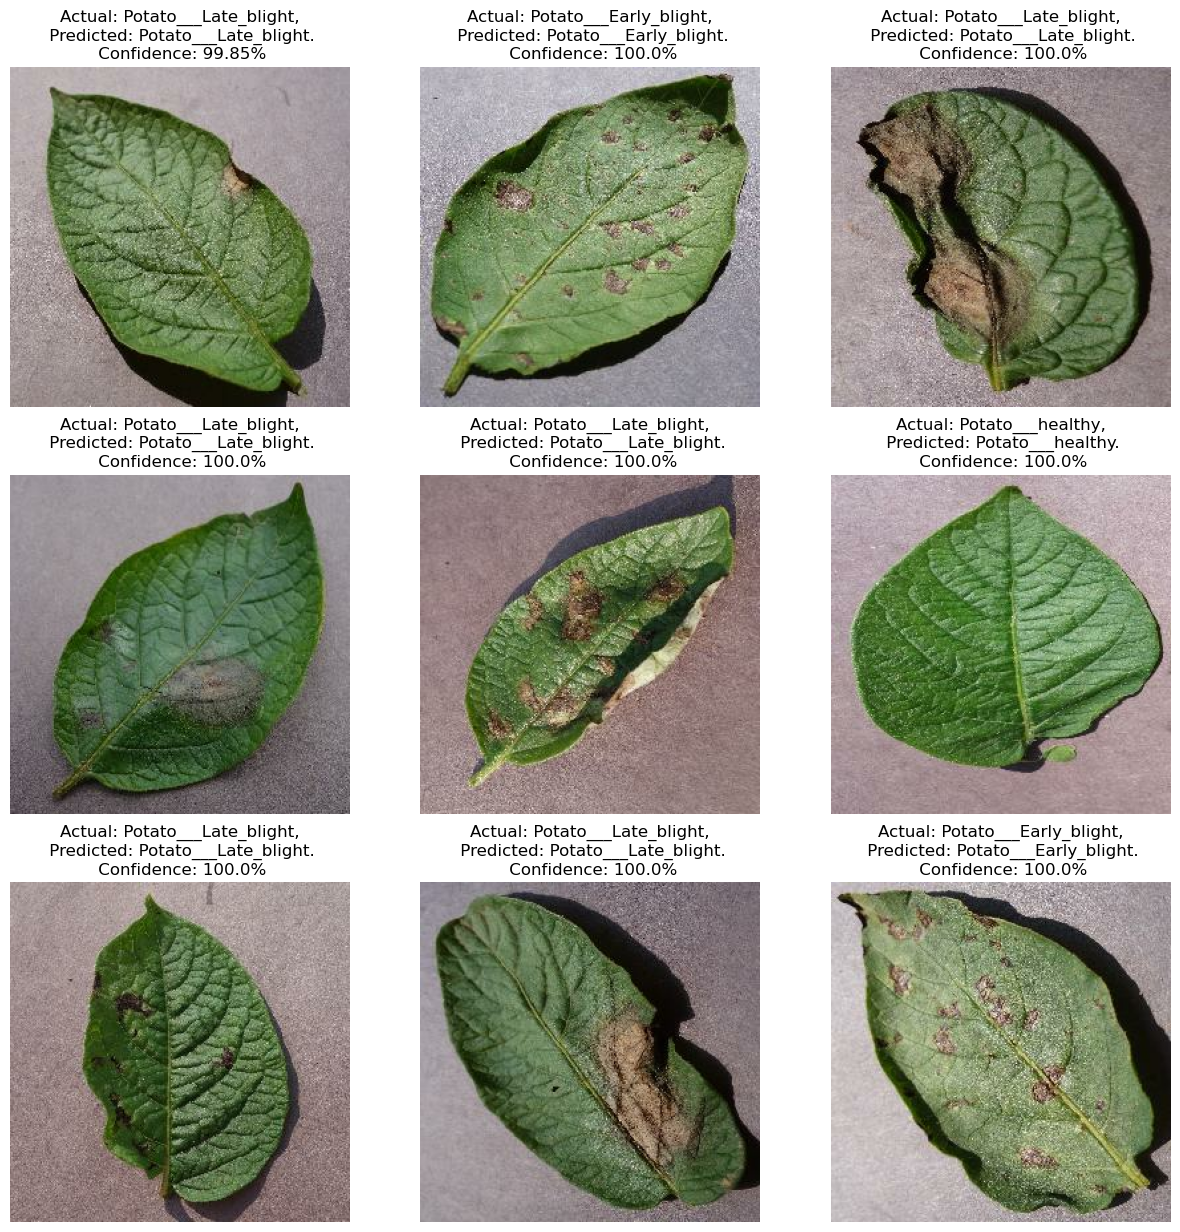

In [55]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

### Saving the Model

In [58]:
import os
model_version=max([int(i) for i in os.listdir("../models") + [0]])+1
model.save(f"../models/{model_version}")

In [59]:
model.save("../potatoes.h5")